## 10. Spatial regression

### Why _spatial_ regression and why does it matter?

What is it that makes _spatial_ regression special and sets it apart from _classical_ regression? In classical ordinary least squares (OLS) regression, we assume that the [Gauss-Markov Theorem](https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem) holds and that the regression model errors are uncorrelated, have equal variances across all samples, and have an expected value of zero (i.e., are unbiased).

However, most socio-economic processes take place in space and influence the spatial distribution of the model errors. Now, this spatial influence can be interpreted in two ways. 

* If we _know_ for sure that the process **generating** the data is explicitly spatial. For example, we know that urban mobility patterns in cities are driven by the spatial patterns of social and economic activity. Or, firms and households choose locations, among other things, based on spatial accessibility to public amenities. In this view, geography is a feature that can be explicitly incorporated into regression models.

* A common approach in classical regression is analysing the distribution of the model errors. Among various error diagnostic tools, spatial regression offers yet another powerful method to assess if there are _systematic_ errors, such as spatial clusters of model errors, in our model. This occurs in cases when some spatial relationship or structure **_should be_** included as a feature in our model, but we do not know how to include it in the model. Or, it can happen due to the complex interdependencies among features that carry embodied spatial information and interact with each other causing spatially patterned effect which is difficult to capture. 

In both cases, additional information about the different kinds of spatial relationships among samples or nearby locations can improve our model. This kind of spatial feature engineering was the topic of our previous class.

In this class, we will learn about spatial regression models and their properties, and will use them to analyse Airbnb listing prices in San Diego. This Jupyter Notebook is a modified and extended version of [this](https://geographicdata.science/book/notebooks/11_regression.html#bringing-space-into-the-regression-framework) great chapter of the [Geographic Data Science](https://geographicdata.science/book/intro.html) book.

In [1]:
%matplotlib inline

from pysal.model import spreg
from pysal.lib import weights
from pysal.explore import esda
from scipy import stats
import statsmodels.formula.api as sm
import numpy
import pandas
import geopandas as gpd, pandas as pd
import matplotlib.pyplot as plt
import seaborn
import osmnx as ox

C:\Users\gevor\anaconda3\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.4.3-CAPI-1.8.3 r4285) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# in case of encountering problems with GEOS or GDAL, disable speedups from shapely
from shapely import speedups
speedups.disable()

In [3]:
db = gpd.read_file("../data/san_diego_regr_data.geojson")
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6092 entries, 0 to 6091
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   accommodates        6092 non-null   int64   
 1   bathrooms           6092 non-null   float64 
 2   bedrooms            6092 non-null   float64 
 3   beds                6092 non-null   float64 
 4   neighborhood        6092 non-null   object  
 5   pool                6092 non-null   int64   
 6   d2balboa            6092 non-null   float64 
 7   coastal             6092 non-null   int64   
 8   price               6092 non-null   float64 
 9   log_price           6092 non-null   float64 
 10  id                  6092 non-null   int64   
 11  pg_Apartment        6092 non-null   int64   
 12  pg_Condominium      6092 non-null   int64   
 13  pg_House            6092 non-null   int64   
 14  pg_Other            6092 non-null   int64   
 15  pg_Townhouse        6092 non-n

In [4]:
print(db.crs)
db.head()

epsg:4326


,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,...,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,balboa_dist,park_dist,counts_normalised,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,...,1,0,0,1,0,0,1776.874,1776.874,0.000007,POINT (-117.12971 32.75399)
1,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,...,0,0,0,0,1,0,1540.368,1540.368,0.000007,POINT (-117.14121 32.75327)
2,2,0.0,1.0,1.0,North Hills,1,2.548985,0,65.0,4.174387,...,0,1,0,1,0,0,2595.122,2595.122,0.000007,POINT (-117.11918 32.73188)
3,2,1.0,1.0,1.0,North Hills,0,1.791777,0,42.0,3.737670,...,0,0,0,0,1,0,583.347,583.347,0.000007,POINT (-117.14423 32.74730)
4,2,1.0,1.0,1.0,North Hills,0,1.642844,0,47.0,3.850148,...,0,0,0,0,1,0,501.974,501.974,0.000007,POINT (-117.14406 32.74594)


These are the main (non-spatial) explanatory or predictive variables we will use for this regression excercise.

In [5]:
variable_names = [
    'accommodates', 
    'bathrooms', 
    'bedrooms', 
    'beds', 
    'rt_Private_room', 
    'rt_Shared_room',
    'pg_Condominium', 
    'pg_House', 
    'pg_Other', 
    'pg_Townhouse'
]

### Classical regression

Before we move on to spatial regression, let's first look at what classical regression has to offer for this project.
As we know, classical linear regression is about explaining the variation of a **_dependent_** variable as a linear combination of other, **_independent_** or **_explanatory_** variables. For example, the Airbnb listing prices can be modelled as:

$$
P_{i}=\alpha+\sum_{k} \mathbf{X}_{i k} \beta_{k}+\epsilon_{i},
$$

where $P_{i}$ is the price of Airbnb listing $i$, and $X$ is a set of covariates that we assume to being able to explain the price. $\beta$ is the vector of parameters we are trying to estimate, containing information about the way and the extent each varable is related to the price, and $\alpha$ is the constant term that can be interpreted as being the average of the prices when all explanatory variables are zero. Finally, the error term $\epsilon_{i}$ can be interpreted as capturing the influence of factors not included in the model.

Python offers many standard tools for working with linear regressions: [statsmodels](https://www.statsmodels.org/stable/index.html), [scikit-learn](https://scikit-learn.org/stable/modules/linear_model.html), and [PySAL](https://pysal.org/spreg/) - our main tool for this project. 

Here is the basic code structure for running a simple linear regression model with the `spreg` sub-package of the `PySAL` package:

In [6]:
m1 = spreg.OLS(
    db[['log_price']].values, 
    db[variable_names].values,
    name_y='log_price', 
    name_x=variable_names
)

After which, inspecting the regression results is even easier:

In [7]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6092
Mean dependent var  :      4.9976                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6081
R-squared           :      0.6681
Adjusted R-squared  :      0.6676
Sum squared residual:    1317.265                F-statistic           :   1224.1294
Sigma-square        :       0.217                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3979.472
Sigma-square ML     :       0.216                Akaike info criterion :    7980.944
S.E of regression ML:      0.4650                Schwarz criterion     :    8054.806

-----------------------------------------------------------------------------

### Hidden spatial structures

For a simple regression model, our results are already quite good, predicting roughly 67% (R^2 = 0.67) of the variation in the mean Airbnb listing prices in San Diego, based on the explanatory variables we have included in the model so far. However, as discussed above, our model might result in some spatial clustering of errors. One simple way to check this is looking at **the correlation between the error in predicting an AirBnB and the error in predicting its nearest neighbor**. To see this, we first split our data up by regions and see if we've got some spatial structure in our residuals. Domain knowledge or just common sense tells us that our model might not include any information about beaches, an important factor for why people live and come for vacation to San Diego. Therefore, we might want to see whether or not our errors are higher or lower depending on whether or not an AirBnB is in a coastal neighbourhood:

In [8]:
m1.u

array([[ 0.649736  ],
       [ 0.28788249],
       [-0.63367796],
       ...,
       [-1.07852021],
       [ 0.10345214],
       [ 0.30599187]])

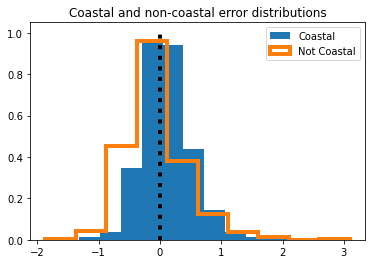

In [9]:
is_coastal = db.coastal.astype(bool)
coastal = m1.u[is_coastal]
not_coastal = m1.u[~is_coastal]
plt.hist(coastal, density=True, label='Coastal')
plt.hist(
    not_coastal, 
    histtype='step',
    density=True, 
    linewidth=4, 
    label='Not Coastal'
)
plt.vlines(0,0,1, linestyle=":", color='k', linewidth=4)
plt.legend()
plt.title("Coastal and non-coastal error distributions")
plt.show()

To statistically ascertain the difference in the error distributions we see above, we use a simple [T-test](https://en.wikipedia.org/wiki/Student%27s_t-test):

In [10]:
stats.ttest_ind(coastal, not_coastal)

Ttest_indResult(statistic=array([13.95970895]), pvalue=array([1.28345431e-43]))

We should be careful with one-off hypotheses regarding the spatial desirability of locations in San Diego. It might be the case that a location close to the beach, for example, might fall behind in desirability due to pollution or noise, despite its proximity to the ocean. Therefore, a more intelligent thing to do is to look at the full distribution of model residuals in each neighbourhood.

To achieve visual clarity, let's first sort the data by the median residual in that neighborhood, and then make a box plot displaying the distribution of residuals in each neighborhood:

In [11]:
db['residual'] = m1.u
medians = db.groupby(
    "neighborhood"
).residual.median().to_frame(
    'hood_residual'
)
medians.head()

,hood_residual
neighborhood,
Balboa Park,-0.165343
Bay Ho,-0.180042
Bay Park,-0.063332
Carmel Valley,-0.003527
City Heights West,-0.327146


In [12]:
db.head()

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,...,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,balboa_dist,park_dist,counts_normalised,geometry,residual
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,...,0,0,1,0,0,1776.874,1776.874,0.000007,POINT (-117.12971 32.75399),0.649736
1,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,...,0,0,0,1,0,1540.368,1540.368,0.000007,POINT (-117.14121 32.75327),0.287882
2,2,0.0,1.0,1.0,North Hills,1,2.548985,0,65.0,4.174387,...,1,0,1,0,0,2595.122,2595.122,0.000007,POINT (-117.11918 32.73188),-0.633678
3,2,1.0,1.0,1.0,North Hills,0,1.791777,0,42.0,3.737670,...,0,0,0,1,0,583.347,583.347,0.000007,POINT (-117.14423 32.74730),-0.713395
4,2,1.0,1.0,1.0,North Hills,0,1.642844,0,47.0,3.850148,...,0,0,0,1,0,501.974,501.974,0.000007,POINT (-117.14406 32.74594),-0.600917


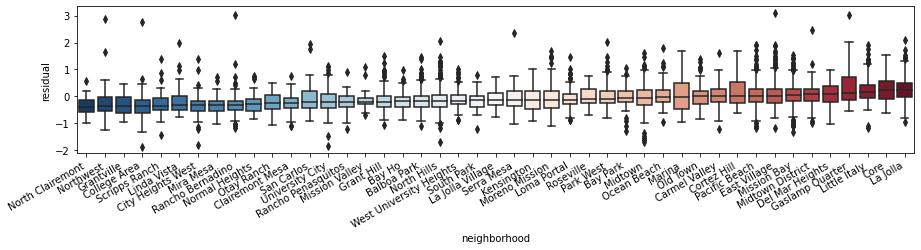

In [13]:
f = plt.figure(figsize=(15,3))
ax = plt.gca()
seaborn.boxplot(
    x= 'neighborhood', 
    y= 'residual', 
    ax = ax,
    data=db.merge(
        medians, 
        how='left',
        left_on='neighborhood',
        right_index=True
    ).sort_values(
        'hood_residual'), palette='RdBu_r'
)
f.autofmt_xdate()
plt.show()

No neighborhood pops out visually compared to others, but some do indeed have higher residuals, such as the well-known downtown tourist neighborhoods areas of the Gaslamp Quarter, Little Italy, or The Core. Thus, there may be a spatial effect of intangible neighborhood attractiveness that makes a difference in this model.

Another important aspect we need to consider is a possible _spillover_ of model errors in neighbourhoods to their immediate geogrpahic neighbours. This can be due to the fact that people tend to price their listings similarly to their neighbours in an attempt to fit into the competition. Since our simple regression model does not account for this kind of behaviour, errors might form spatial clusters. One simple way to check if this is true, is to plot the relationship between a sample's residuals and its surrounding residuals.

To do this, we will use **_spatial weights_** we saw in a previous class, to encode the geographic relationships between samples. We start start with a KNN matrix where k=1, representing the linkages of each AirBnB to their closest other listing.

In [14]:
knn = weights.KNN.from_dataframe(db, k=1)

C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 1847 disconnected components.
  warnings.warn(message)


This means that, when we compute the spatial lag of that KNN weight and the residual, we get the residual of the AirBnB listing closest to each sample.

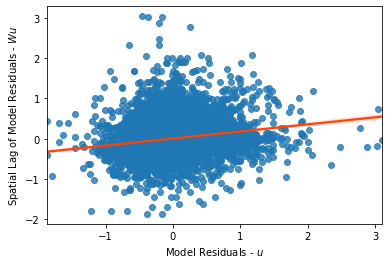

In [15]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
ax = seaborn.regplot(
    x = m1.u.flatten(), 
    y = lag_residual.flatten(), 
    line_kws=dict(color='orangered')
)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$');

In the plot above, we see that there indeed is a spatial clustering of model errors. In simple words, when the model tends to over-predict a given Airbnb listing price, it is more likely to over-predict the prices close to it as well.

Of course, as we grow the number of k nearest neighbours, this relationship will stabilise as differences will be smoothed out.
Given this behavior, let's look at the stable k = 20 number of neighbors. Examining the relationship between this stable surrounding average and the focal AirBnB, we can even find clusters in our model error. Recalling the local Moran statistic, we can identify certain areas where our predictions of the AirBnB price tend to be significantly off:

C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


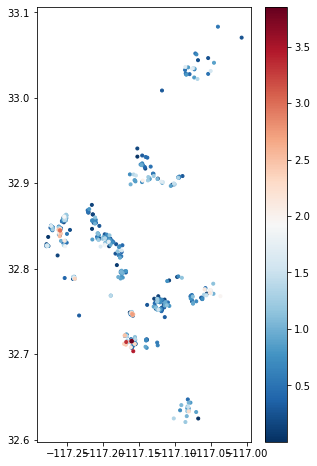

In [16]:
knn.reweight(k=20, inplace=True)
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)
error_clusters = (outliers.q % 2 == 1) # only the cluster cores
error_clusters &= (outliers.p_sim <= .001) # filtering out non-significant clusters
db_I = db.assign(
    error_clusters = error_clusters,
    local_I = outliers.Is
).query(
    "error_clusters"
).sort_values(
    'local_I'
)

f, ax = plt.subplots(1, figsize=(5, 8))
db_I.plot('local_I', cmap='RdBu_r', marker='.', ax=ax, legend=True)
plt.show()

These are the locations where our model significantly mispredicts both the sample price and the prices in its immediate surroudnings. If we could model the spatial structure of these areas and incorporate it in our model, we would be able to improve our results.

### Introducing space into the regression framework

Essentially, we want to introduce space into our regression framework when we think it plays an important role in the process we are studying, or when space can act as a reasonable proxy for other factors we cannot but should include in our model.

Such proxies are typically built as new features representing different kinds of spatial relationships between the observations or nearby locations. We have covered this as part of spatial feature engineering. One such example can be the spatial feature we constructed last time: the distance to Balboa Park - a famous park that contains a zoo and is a popular recreational area in San Diego. We can conjecture that people might be willing to pay more for proximity to the park. If this were true **_and_** we omitted it from our model, we woould indeed see a spatial pattern in the distribution of residuals.

Therefore, let’s build a new model containing this distance to Balboa Park covariate. First, though, it helps to visualize the structure of this distance covariate itself:

In [17]:
db["balboa_dist"] = pd.to_numeric(db["balboa_dist"], downcast="float") # convert the feature from string to float

<AxesSubplot:>

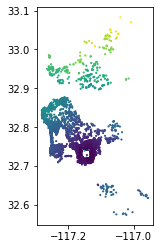

In [18]:
db.plot('balboa_dist', marker='.', s=5)

In [19]:
# construct new variables
base_names = variable_names
balboa_names = variable_names + ['balboa_dist']

Now, let's run the new model with the new variables:

In [20]:
m2 = spreg.OLS(
    db[['log_price']].values, 
    db[balboa_names].values, 
    name_y = 'log_price', 
    name_x = balboa_names
)

In [21]:
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6092
Mean dependent var  :      4.9976                Number of Variables   :          12
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6080
R-squared           :      0.6686
Adjusted R-squared  :      0.6680
Sum squared residual:    1315.273                F-statistic           :   1115.1847
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3974.861
Sigma-square ML     :       0.216                Akaike info criterion :    7973.723
S.E of regression ML:      0.4647                Schwarz criterion     :    8054.300

-----------------------------------------------------------------------------

Unfortunately, when we look at the regression diagnostics above, we see that this explanatory variable is not quite as helpful as we expected. It is not statistically significant at conventional significance levels, the model fit does not substantially change, and, there still appears to be spatial structure in our model's residuals:

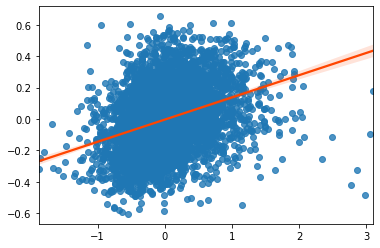

In [22]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m2.u)
seaborn.regplot(
    x = m2.u.flatten(), 
    y = lag_residual.flatten(), 
    line_kws=dict(color='orangered')
);

Most importantly, the distance to Balboa Park variable does not fit our theory about how distance to amenity should affect the price of an AirBnB; the coefficient estimate is positive, meaning that people are paying a premium to be further from the Park. 

So, let's try the distance to the _closest_ park instead of the distance to Balboa park.

<AxesSubplot:>

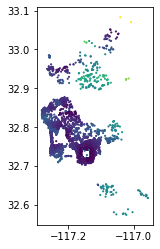

In [23]:
db.plot('park_dist', marker='.', s=5)

In [24]:
# construct new variables
base_names = variable_names
closest_park_names = variable_names + ['park_dist']

Now, let's run the new model with the new variables:

In [25]:
m2_1 = spreg.OLS(
    db[['log_price']].values, 
    db[balboa_names].values, 
    name_y = 'log_price', 
    name_x = closest_park_names
)

In [26]:
print(m2_1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6092
Mean dependent var  :      4.9976                Number of Variables   :          12
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6080
R-squared           :      0.6686
Adjusted R-squared  :      0.6680
Sum squared residual:    1315.273                F-statistic           :   1115.1847
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3974.861
Sigma-square ML     :       0.216                Akaike info criterion :    7973.723
S.E of regression ML:      0.4647                Schwarz criterion     :    8054.300

-----------------------------------------------------------------------------

Another disappointment... no significant effect here as well.

### Spatial heterogeneity

So far, we have assumed that our spatial proximity variable represents the willingness to pay more for being close to a recreational zone. However, not all neighborhoods are qually attractive; some neighborhoods may be more lucrative than others, regardless of their proximity to Balboa Park. When this is the case, we need some way to account for the fact that each neighborhood may experience these kinds of unique effects. One way to do this is by capturing **_spatial heterogeneity_**. In principle, **spatial heterogeneity means that the parameters of the model may change in different places**. For example, changes to the intercept, $\alpha$, may reflect the fact that different areas have different baseline exposures to a given process. Changes to the slope terms, $\beta$, may indicate some kind of geographical influence factor, such as when a government policy is applied differently across areas. Finally, changes to the variance of the residuals, commonly denoted $\sigma^{2}$, can introduce spatial heteroskedasticity. We deal with the first two below.

To illustrate this, we start by allowing a different constant term in different neighbourhoods, i.e. we consider a variable constant term across neighbourhoods. To achieve this, we create a dummy variable denoting whether an Airbnb listing belongs to a given neighbourhood (`1`) or not (`0`). Now our regression equation becomes:

$$
\log P_{i}=\alpha_{r}+\sum_{k} \mathbf{X}_{i k} \beta_{k}+\epsilon_{i}
$$

where, as you can see, we are now allowing the constant term, $\alpha$, to vary by neighborhood $r$, $\alpha_{r}$. 

We will implement the above model in two different ways. First, we look at `statsmodels`. This package provides a formula-like API, which allows us to express the equation we wish to estimate directly:

In [27]:
f = 'log_price ~ ' + ' + '.join(variable_names) + ' + neighborhood - 1'
print(f)

log_price ~ accommodates + bathrooms + bedrooms + beds + rt_Private_room + rt_Shared_room + pg_Condominium + pg_House + pg_Other + pg_Townhouse + neighborhood - 1


The `~` operator in the above statement is usually read as "log price is a function of …", to account for the fact that many different model specifications can be fit according to that functional relationship between log_price and our explamatory variable list. Critically, note that the trailing -1 term means that we are fitting this model without an intercept term. This is necessary, since including an intercept term alongside unique means for every neighborhood would make the underlying system of equations underspecified. Now we can estimate the unique effects of each neighbourhood:

In [28]:
m3 = sm.ols(f, data=db).fit()
print(m3.summary2())

                           Results: Ordinary least squares
Model:                      OLS                    Adj. R-squared:           0.709    
Dependent Variable:         log_price              AIC:                      7210.0765
Date:                       2021-07-21 21:13       BIC:                      7579.3867
No. Observations:           6092                   Log-Likelihood:           -3550.0  
Df Model:                   54                     F-statistic:              276.1    
Df Residuals:               6037                   Prob (F-statistic):       0.00     
R-squared:                  0.712                  Scale:                    0.18951  
--------------------------------------------------------------------------------------
                                       Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------------------------
neighborhood[Balboa Park]              4.2800   0.0333 128.5313 0.0000 

Here is the PySAL [`OLS_Regimes`](https://spreg.readthedocs.io/en/latest/generated/spreg.OLS_Regimes.html) implementation of the above technique:

In [29]:
# PySAL implementation
m4 = spreg.OLS_Regimes(
    db[['log_price']].values, 
    db[variable_names].values,
    db['neighborhood'].tolist(),
    constant_regi='many',
    cols2regi=[False]*len(variable_names),
    regime_err_sep=False,
    name_y='log_price', 
    name_x=variable_names
)
print(m4.summary)

C:\Users\gevor\anaconda3\lib\site-packages\spreg\diagnostics.py:585: ComplexWarning: Casting complex values to real discards the imaginary part
  ci_result = sqrt(max_eigval / min_eigval)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6092
Mean dependent var  :      4.9976                Number of Variables   :          55
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6037
R-squared           :      0.7118
Adjusted R-squared  :      0.7092
Sum squared residual:    1144.050                F-statistic           :    276.0506
Sigma-square        :       0.190                Prob(F-statistic)     :           0
S.E. of regression  :       0.435                Log likelihood        :   -3550.038
Sigma-square ML     :       0.188                Akaike info criterion :    7210.076
S.E of regression ML:      0.4334                Schwarz criterion     :    7579.387

---------------------------------------------------------

What the neighborhood fixed effects we have introduced imply is that, instead of comparing all Airbnb listing prices across San Diego as equal, we only model variation from within each neighbourhood. Remember that the interpretation of $\beta_{k}$ is the effect of variable $k$, given all the other explanatory variables included remain **_constant_**. By including a single variable for each area, we are effectively forcing the model to consider the group of Airbnb listing prices located within the same area. This allows a better control of unobserved effects since we consider those spatially aligned with e fixed effects we introduced.

To make a map of neighborhood fixed effects, we need to process the results from our model slightly.
First, we extract only the effects corresponding to the neighborhoods:

In [30]:
neighborhood_effects = m3.params.filter(like='neighborhood')
neighborhood_effects.head()

neighborhood[Balboa Park]          4.280013
neighborhood[Bay Ho]               4.197322
neighborhood[Bay Park]             4.328163
neighborhood[Carmel Valley]        4.388050
neighborhood[City Heights West]    4.052922
dtype: float64

Next, we need to extract only the neighborhood name from the index of this Series. A simple way to do this is to strip all the characters that come before and after our neighborhood names:

In [31]:
stripped = neighborhood_effects.index.str.strip('neighborhood[').str.strip(']')
neighborhood_effects.index = stripped
neighborhood_effects = neighborhood_effects.to_frame('fixed_effect')
neighborhood_effects.head()

,fixed_effect
Balboa Park,4.280013
Bay Ho,4.197322
Bay Park,4.328163
Carmel Valley,4.388050
City Heights West,4.052922


Now we have to join this dataframe with the neighbourhood geometry:

In [32]:
neighborhoods = gpd.read_file('../data/neighbourhoods_san_diego.geojson')
neighborhoods.head()

,neighbourhood,neighbourhood_group,geometry
0,Amphitheater And Water Park,None,"MULTIPOLYGON (((-117.01452 32.58790, -117.0144..."
1,Bella Lago,None,"MULTIPOLYGON (((-116.94128 32.68431, -116.9412..."
2,Bonita Long Canyon,None,"MULTIPOLYGON (((-117.01149 32.66352, -117.0114..."
3,East Lake,None,"MULTIPOLYGON (((-116.99302 32.66040, -116.9816..."
4,Eastlake Trails,None,"MULTIPOLYGON (((-116.95512 32.64124, -116.9550..."


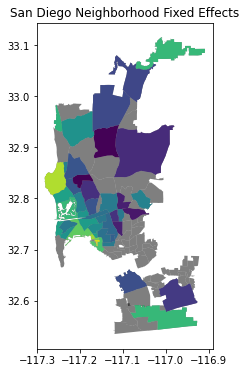

In [33]:
ax = neighborhoods.plot(
    color='k', alpha=0.5, figsize=(12,6)
)
neighborhoods.merge(
    neighborhood_effects, 
    how='left',
    left_on='neighbourhood', 
    right_index=True).dropna(subset=['fixed_effect']).plot('fixed_effect', ax=ax)

ax.set_title("San Diego Neighborhood Fixed Effects")
plt.show()

### Spatial Regimes

The main idea of estimating spatial fixed effects is that, instead of assuming the dependent variable behaves uniformly over space, there are systematic effects following a geographical pattern that affect its behavior. In other words, spatial fixed effects have _spatial heterogeneity_. This is modelled in the simplest possible form: by allowing the constant term to vary geographically. The other elements of the regression apply uniformly across space. The idea of spatial regimes (SRs) is to generalize the spatial fixed effect approach to allow not only the constant term to vary but also any other explanatory variable. Our regression model in this setting then becomes:

$$
\log P_{i}=\alpha_{r}+\sum_{k} \mathbf{X}_{k i} \beta_{k-r}+\epsilon_{i}
$$

where we are not only allowing the constant term to vary by region ($\alpha_{r}$), but also every other parameter ($\beta_{k-r}$).

To show this, we will use the `coastal_neigh` variable denoting whether a house is in a coastal neighborhood or not to define the spatial regimes. The reasoning behind this is that renting an Airbnb close to the ocean might be a strong enough motivation that people might be willing to pay different rates for each of the Airbnb listing's characteristics.

In [34]:
m4 = spreg.OLS_Regimes(
    db[['log_price']].values, 
    db[variable_names].values,
    db['coastal'].tolist(),
    constant_regi='many',
    regime_err_sep=False,
    name_y='log_price', 
    name_x=variable_names
)
print(m4.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6092
Mean dependent var  :      4.9976                Number of Variables   :          22
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6070
R-squared           :      0.6851
Adjusted R-squared  :      0.6840
Sum squared residual:    1249.913                F-statistic           :    628.7941
Sigma-square        :       0.206                Prob(F-statistic)     :           0
S.E. of regression  :       0.454                Log likelihood        :   -3819.605
Sigma-square ML     :       0.205                Akaike info criterion :    7683.211
S.E of regression ML:      0.4530                Schwarz criterion     :    7830.935

---------------------------------------------------------

### Spatial dependence

Spatial heterogeneity, SH, is about modelling phenomena that are explicitly linked to geography and that hence cause spatial variation and clustering. This includes many of the kinds of spatial effects we may be interested in when we fit linear regressions. However, in other cases, our focus is on the effect of the spatial configuration of the observations or their mutual spatial relationships, and the extent to which that has an effect on the outcome we are considering. In this setting, we will be interested in capturing not only the characteristics of an Airbnb listing, but also of its surrounding ones.

This kind of spatial effect is fundamentally different from spatial heterogeneity in that it is not directly related to inherent characteristics of the geography but relates to the characteristics of the observations in our dataset and, specially, to their spatial arrangement. This spatial effect, in which the values of observations are related to each other through their mutual spatial arrangement and distance, is called **_spatial dependence_**.

Spatial dependence is typically incorporated into regression models via **_spatial weight matrices (W)_**.

### Exogenous effects: The SLX Model

Let us return to the Airbnb listing price example we have been working with. So far, we have hypothesized that the price of an Airbnb listing rented in San Diego through AirBnB can be explained using information about its own characteristics as well as some relating to its location such as the neighborhood or the distance to the main park in the city. However, it is also reasonable to think that potential renters care about the larger area around a location, and not only about the Airbnb listing itself, and would be willing to pay more for an Airbnb listing that was surrounded by certain types of other Airbnb listings, and less if it was located in the middle of other types. 

The simplest way to introduce **_spatial dependence_** in a regression is by considering not only a given explanatory variable, but also its spatial lag. In our example, in addition to including a dummy for the type of Airbnb listing (`pg_XXX`), we can also include the spatial lag of each type of Airbnb listing. This addition implies we are also including as explanatory factor of the price of a given Airbnb listing the proportion of the neighboring listings in each type. This implies estimating the following regression model:

$$
\log \left(P_{i}\right)=\alpha+\sum_{k=1}^{p} X_{i j} \beta_{j}+\sum_{k=1}^{p}\left(\sum_{j=1}^{N} w_{i j} x_{j k}\right) \gamma_{k}+\epsilon_{i}
$$

where $\sum_{j=1}^{N} w_{i j} x_{j k}$ is the spatial lag of the $k$th explanatory variable. In matrix form, the above equation becomes $\log \left(P_{i}\right)=\alpha+\mathbf{X} \beta+\mathbf{W} \mathbf{X} \gamma+\epsilon$.

As we see, the model is made of two main effects, $\beta$ and $\gamma$. As we know, $\beta$ shows the percentage change in the listing prices resulting from a unit change in the explanatory variables. $\gamma$, on the other hand, can be interpreted in two ways. First, one could think of $\gamma$ as simply **the effect of a unit change in your average surroundings**.

This is useful and simple. But, this interpretation ignores where this change might occur. In truth, a change in a variable at site $i$ will result in a spillover to its surroundings: when $x_i$ changes, so too does the spatial lag of any site near $i$. The precise size of this will depend on the structure of $\mathbf{W}$, and can be different for every site.

Thus, to discover the exact indirect effect of a change in $y$ caused by the change at a specific site $x_i$ we would need to compute the change in the spatial lag, and then use that as our change in $X$.

In Python, we can calculate the spatial lag of each variable whose name starts by `pg_` by first creating a list of all of those names, and then applying PySAL's `lag_spatial` method to each of them:

In [35]:
wx = db.filter(
    like='pg'
).apply(
    lambda y: weights.spatial_lag.lag_spatial(knn, y)
).rename(
    columns=lambda c: 'w_'+c
).drop(
    'w_pg_Apartment', axis=1
)

In [36]:
wx

,w_pg_Condominium,w_pg_House,w_pg_Other,w_pg_Townhouse
0,0.00,0.45,0.2,0.00
1,0.05,0.30,0.0,0.05
2,0.00,0.95,0.0,0.00
3,0.05,0.30,0.1,0.10
4,0.05,0.25,0.1,0.05
...,...,...,...,...
6087,0.05,0.75,0.0,0.15
6088,0.05,0.80,0.0,0.10
6089,0.05,0.75,0.0,0.15
6090,0.05,0.80,0.0,0.10


Once computed, we can run the model using OLS estimation because, in this context, the spatial lags included do not violate any of the assumptions OLS relies on (they are essentially additional exogenous variables):

In [37]:
slx_exog = db[variable_names].join(wx)
m5 = spreg.OLS(
    db[['log_price']].values, 
    slx_exog.values,
    name_y='l_price', 
    name_x=slx_exog.columns.tolist()
)
print(m5.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     l_price                Number of Observations:        6092
Mean dependent var  :      4.9976                Number of Variables   :          15
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6077
R-squared           :      0.6797
Adjusted R-squared  :      0.6790
Sum squared residual:    1271.098                F-statistic           :    921.3062
Sigma-square        :       0.209                Prob(F-statistic)     :           0
S.E. of regression  :       0.457                Log likelihood        :   -3870.800
Sigma-square ML     :       0.209                Akaike info criterion :    7771.601
S.E of regression ML:      0.4568                Schwarz criterion     :    7872.322

-----------------------------------------------------------------------------

The spatial lag of each type of property (`w_pg_XXX`) is the new addition. We observe that, except for the case of townhouses (same as with the binary variable, pg_Townhouse), they are all significant, suggesting our initial hypothesis on the role of the surrounding Airbnb listings might indeed be at work here.

Any given house surrounded by condominiums receives a price premium. So, a unit change (or, a 100% change) in `w_pg_Condominium` would result in a 58.2% increase in the Airbnb listing price.

However, to compute the indirect change for a given site $i$, we may need to examine the predicted values for $y_i$. In this example, since we are using a row-standardized weights matrix with 20 nearest neighbors, the impact of changing $x_i$ is the same for all of its neighbors and for any site $i$. Thus, the effect is always $\gamma/20$, or about 0.0291. However, this would not be the same for many other kinds of weights (like Kernel, Queen, Rook, DistanceBand, or Voronoi), so we will demonstrate how to construct the indirect effect for a specific $i$:

Firstly, predicted values for $y_i$ are stored in the `predy` attribute of any model:

In [38]:
m5.predy

array([[5.43827103],
       [4.25355342],
       [4.61249384],
       ...,
       [4.89754676],
       [4.17134921],
       [4.09039928]])

Showing this process below, let’s first change a property to be a condominium. Consider the third observation, which is the first apartment in the data:

In [39]:
db.loc[5]

accommodates                                                     2
bathrooms                                                        1
bedrooms                                                         1
beds                                                             1
neighborhood                                           North Hills
pool                                                             0
d2balboa                                                   2.64891
coastal                                                          0
price                                                           99
log_price                                                  4.59512
id                                                          122458
pg_Apartment                                                     1
pg_Condominium                                                   0
pg_House                                                         0
pg_Other                                                      

This is an apartment. Let’s make a copy of our data and change this apartment into a condominium:

In [40]:
db_scenario = db.copy()
# make Apartment 0 and condo 1
db_scenario.loc[5, ['pg_Apartment', 'pg_Condominium']] = [0,1]

In [41]:
db_scenario.loc[5]

accommodates                                                     2
bathrooms                                                        1
bedrooms                                                         1
beds                                                             1
neighborhood                                           North Hills
pool                                                             0
d2balboa                                                   2.64891
coastal                                                          0
price                                                           99
log_price                                                  4.59512
id                                                          122458
pg_Apartment                                                     0
pg_Condominium                                                   1
pg_House                                                         0
pg_Other                                                      

Now, we need to also update the spatial lags:

In [42]:
wx_scenario = db_scenario.filter(
    like='pg'
).apply(
    lambda y: weights.spatial_lag.lag_spatial(knn, y)
).rename(
    columns=lambda c: 'w_'+c
).drop(
    'w_pg_Apartment', axis=1
)

And build a new exogenous $\mathbf{X}$ matrix, including the constant 1 as the leading column:

In [43]:
slx_exog_scenario = db_scenario[variable_names].join(wx_scenario)
slx_exog_scenario.head()

,accommodates,bathrooms,bedrooms,beds,rt_Private_room,rt_Shared_room,pg_Condominium,pg_House,pg_Other,pg_Townhouse,w_pg_Condominium,w_pg_House,w_pg_Other,w_pg_Townhouse
0,5,2.0,2.0,2.0,0,0,0,1,0,0,0.00,0.45,0.2,0.00
1,2,1.0,1.0,1.0,1,0,0,0,0,0,0.10,0.30,0.0,0.05
2,2,0.0,1.0,1.0,0,0,0,0,1,0,0.00,0.95,0.0,0.00
3,2,1.0,1.0,1.0,1,0,1,0,0,0,0.05,0.30,0.1,0.10
4,2,1.0,1.0,1.0,1,0,1,0,0,0,0.05,0.25,0.1,0.05


Now, our new prediction (in the scenario where we have changed site 5 from an apartment into a condominium), is:

In [44]:
y_pred_scenario = m5.betas[0] + slx_exog_scenario @ m5.betas[1:]

In [45]:
m5.betas

array([[ 4.32342051],
       [ 0.08094993],
       [ 0.19004969],
       [ 0.16330497],
       [-0.04510963],
       [-0.52990512],
       [-1.29637301],
       [ 0.10740416],
       [ 0.03430063],
       [ 0.08752909],
       [-0.02643749],
       [ 0.58245597],
       [-0.08268522],
       [ 0.48259262],
       [-0.28848208]])

This prediction will be exactly the same for all sites, except site 5 and its neighbors. So, the neighbors to site 5 are:

In [46]:
knn.neighbors[5]

[14,
 15,
 344,
 187,
 1,
 111,
 267,
 103,
 70,
 67,
 3766,
 325,
 12,
 224,
 373,
 337,
 3703,
 137,
 101,
 3683]

And the effect of changing site 5 into a condominium results in the following changes to $y_i$:

In [47]:
y_pred_scenario

,0
0,5.438271
1,4.282676
2,4.612494
3,4.394793
4,4.413351
...,...
6087,6.257162
6088,4.171349
6089,4.897547
6090,4.171349


In [48]:
(y_pred_scenario - m5.predy).loc[[5] + knn.neighbors[5]]

,0
5,1.074042e-01
14,2.912280e-02
15,2.912280e-02
344,2.912280e-02
187,2.912280e-02
1,2.912280e-02
111,2.912280e-02
267,2.912280e-02
103,2.912280e-02
70,0.000000e+00


We see the first row, representing the direct effect, is equal exactly to the estimate for `pg_Condominium`.  For the other effects, though, we have only changed `w_pg_Condominium` by .05:

In [49]:
scenario_near_5 = slx_exog_scenario.loc[knn.neighbors[5], ['w_pg_Condominium']]
orig_near_5 = slx_exog.loc[knn.neighbors[5], ['w_pg_Condominium']]
scenario_near_5.join(orig_near_5, lsuffix='_scenario', rsuffix= '_original')

,w_pg_Condominium_scenario,w_pg_Condominium_original
14,0.10,0.05
15,0.10,0.05
344,0.10,0.05
187,0.10,0.05
1,0.10,0.05
111,0.10,0.05
267,0.10,0.05
103,0.10,0.05
70,0.00,0.00
67,0.05,0.05


### Spatial error model

The spatial error model includes a spatial lag in the error term of the equation:

$$
\begin{gathered}
\log P_{i}=\alpha+\sum_{k} \beta_{k} X_{k i}+u_{i} \\
u_{i}=\lambda u_{\text {lag- } i}+\epsilon_{i}
\end{gathered}
$$

where $u_{\text {lag- } i}=\sum_{j} w_{i, j} u_{j}$.

Although it appears similar to the regression models we have seen so far, this specification violates the assumptions about the error term in a classical OLS model. Hence, alternative estimation methods are required, which, thankfully, `PySAL` provides us with.  

In [50]:
m6 = spreg.GM_Error_Het(
    db[['log_price']].values, 
    db[variable_names].values,
    w=knn, 
    name_y='log_price', 
    name_x=variable_names
)
print(m6.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        6092
Mean dependent var  :      4.9976                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6081
Pseudo R-squared    :      0.6653
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       4.4258487       0.0217587     203.4056435       0.0000000
        accommodates       0.0695265       0.0063242      10.9937983       0.00

### Spatial lag model

The spatial lag model introduces a spatial lag of the **_dependent_** variable. The equation we have to estimate in thic case becomes:

$$
\log P_{i}=\alpha+\rho \log P_{\text {lag-i }}+\sum_{k} \beta_{k} X_{k i}+\epsilon_{i}
$$

This violates the OLS assumption about exogeneity of variables. Simply put, this occurs since $P_i$ exists on both "sides" of the equation. Similarly to the case of the spatial error, several techniques have been proposed to overcome this limitation, and PySAL implements several of them. In the example below, we use a [two-stage least squares estimation](https://link.springer.com/book/10.1007%2F978-94-015-7799-1).

In [51]:
m7 = spreg.GM_Lag(
    db[['log_price']].values, 
    db[variable_names].values,
    w=knn, 
    name_y='log_price', 
    name_x=variable_names
)
print(m7.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        6092
Mean dependent var  :      4.9976                Number of Variables   :          12
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6080
Pseudo R-squared    :      0.7054
Spatial Pseudo R-squared:  0.6877

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       2.7499280       0.0729859      37.6775268       0.0000000
        accommodates       0.0698300       0.0048212      14.4838936       0.0000000
           bathrooms       0.1631446       0.0104140      1

Just as in the case of the SLX regression, changes in the spatial lag regression need to be interpreted carefully. Here, `w_log_price` applies uniformly across all observations, and actually changes the effective strength of each of the $\beta$ coefficients. 

### Homework assignment

Build a new spatial feature that you think might influence Airbnb listing prices, and run a spatial regression using that feature.

Complete the homework assignment in a clean Jupyter Notebook, name the notebook **< Name > < Surname > Class 10 Homework** and upload it to Moodle.